## Заметка на будущее: 
При использовании признака customer как части признакового пространства, OHE не будет работать. Но если убрать customer из признакового пространства, то тогда OHE работает, является лучшим encoder'ом и качество модели получается примерно 0.925.

Если же customer оставить, то лучшим encoder'ом получается WOEencoder, но качетсво около 0.88. Пока что мы будем работать на всем признаковом пространстве, но стоит помнить, что без customer качество выходит лучше (что противоречит предыдущим результатам). Стоит еще вернуться к этой ситуации в дальнейшем

Ниже мы будем использовать всё признаковое пространство, включая признак customer

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
data = pd.read_csv('/content/drive/MyDrive/MLDS_coursework/new-data.csv', index_col=0)
data.head()

,customer,age,gender,merchant,category,amount,fraud,amount_outlier,amount_outlier_2,strange_amount,pda,pdg,danger_merch,danger_custm,danger_categ,strange_category,strange_merchant
0,'C1093826151','4','M','M348934600','es_transportation',4.55,0,0,0,0,1,0,0,0,0,0,0
1,'C352968107','2','M','M348934600','es_transportation',39.68,0,0,0,0,0,0,0,0,0,0,0
2,'C2054744914','4','F','M1823072687','es_transportation',26.89,0,0,0,0,1,1,0,0,0,0,0
3,'C1760612790','3','M','M348934600','es_transportation',17.25,0,0,0,0,1,0,0,0,0,0,0
4,'C757503768','5','M','M348934600','es_transportation',35.72,0,0,0,0,0,0,0,0,0,0,0


In [101]:
base_features = ['customer', 'age', 'gender', 'merchant', 'category', 'amount']
# base_features = ['age', 'gender', 'merchant', 'category', 'amount']

In [102]:
categorical_features = data.select_dtypes('object').columns
# categorical_features = data.drop('customer', axis=1).select_dtypes('object').columns
categorical_features

Index(['customer', 'age', 'gender', 'merchant', 'category'], dtype='object')

In [151]:
from sklearn.model_selection import train_test_split

X = data.drop('fraud', axis=1)
y = data['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(X.drop('customer', axis=1), y, test_size=0.3, random_state=13, stratify=y)

In [104]:
# только на базовых признаках
# X_train = X_train[base_features]
# X_test = X_test[base_features]

In [109]:
X_train.head()

,customer,age,gender,merchant,category,amount,amount_outlier,amount_outlier_2,strange_amount,pda,pdg,danger_merch,danger_custm,danger_categ,strange_category,strange_merchant
186026,'C1543555122','2','F','M1823072687','es_transportation',0.18,0,0,0,0,1,0,0,0,0,0
297358,'C1922022324','2','F','M348934600','es_transportation',18.55,0,0,0,0,1,0,0,0,0,0
438185,'C737765767','2','F','M348934600','es_transportation',1.10,0,0,0,0,1,0,0,0,0,0
109074,'C1029994689','3','M','M348934600','es_transportation',6.41,0,0,0,1,0,0,0,0,0,0
566194,'C1734487337','4','F','M1823072687','es_transportation',20.81,0,0,0,1,1,0,0,0,0,0


In [4]:
from sklearn.pipeline import Pipeline

# Search for optimal encoder

In [6]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 384 kB/s 


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

In [84]:
# from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [7]:
from category_encoders.one_hot import OneHotEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders import TargetEncoder, WOEEncoder, MEstimateEncoder

In [111]:
from tqdm import tqdm_notebook

# encoders_list = [OneHotEncoder, LeaveOneOutEncoder, TargetEncoder, WOEEncoder, MEstimateEncoder]

encoders_list = [LeaveOneOutEncoder, TargetEncoder, WOEEncoder, MEstimateEncoder]
for encoder in tqdm_notebook(encoders_list):
    pipe_dif = Pipeline([
        ('categ_enc_', encoder(cols=categorical_features)),
        ('scaler_', StandardScaler()),
        ('model_', LogisticRegression())                
    ])

    crossval_results = cross_validate(
        pipe_dif,
        X_train, 
        y_train, 
        cv=5,
        scoring='average_precision',
        n_jobs=-1,
        return_train_score=True
    )
    print(encoder.__name__, crossval_results['test_score'].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/4 [00:00<?, ?it/s]

LeaveOneOutEncoder 0.8743367866739071
TargetEncoder 0.870976760708271
WOEEncoder 0.8906460614679963
MEstimateEncoder 0.8723468008116132


Получили, что лучший score мы получаем при WOEencoder. Его и будем использовать дальше. 

# Feature selection

## univariate selection

In [115]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

In [117]:
k_list = np.arange(1, 17)

for k in tqdm_notebook(k_list):
    pipe = Pipeline([
        ('categ_enc_', WOEEncoder(cols=categorical_features)),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=k)),
        ('model_', LogisticRegression())
    ])

    crossval_results = cross_validate(
        pipe, 
        X_train, 
        y_train,
        cv=5, 
        scoring='average_precision',
        return_train_score=True
    )
    print(k, crossval_results['test_score'].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/16 [00:00<?, ?it/s]

1 0.6931214786066304
2 0.6934417788168498
3 0.6934417788168498
4 0.8570437781059743
5 0.8584577280893303
6 0.8602612208681295
7 0.8608382233618306
8 0.8614539008825254
9 0.8623091929884179
10 0.8622176708075051
11 0.8842406208965082
12 0.8845579840755289


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


13 0.887702314160016


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


14 0.890933988857736


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


15 0.8906486732698096


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


16 0.8906460614679963


In [ ]:
# выполнение ячейки выше заняло 1час 20мин
# лучший показатель - при 14 фичах 0.890933988857736

## recursive selection

In [82]:
from sklearn.feature_selection import RFE

In [127]:
k_best = 14

In [139]:
pipe_rfe = Pipeline([
    ('cat_encoder_', WOEEncoder(cols=categorical_features)),
    ('scaler_', StandardScaler()),
    ('selector_', RFE(LogisticRegression(max_iter=10000),
                      n_features_to_select=k_best,
                      step=30)), 
    ('model_', LogisticRegression())])

In [140]:
cv_res3 = cross_validate(pipe_rfe, X_train, y_train, cv=5, scoring='average_precision', return_train_score=True)
cv_res3['test_score'].mean()

0.8910167629233783

In [ ]:
# заняло 2 минуты
# 14 фичей - 0.8910167629233783

## model-based selection

In [130]:
from sklearn.feature_selection import SelectFromModel

In [141]:
pipe_lasso =  Pipeline([
    ('cat_encoder_', WOEEncoder(cols=categorical_features)),
    ('scaler_', StandardScaler()),
    ('selector_', SelectFromModel(LogisticRegression(max_iter=10000), threshold=1e-5)), 
    ('model_', LogisticRegression())])

In [142]:
cv_res4 = cross_validate(pipe_lasso, X_train, y_train, cv=5, scoring='average_precision', return_train_score=True)
cv_res4['test_score'].mean()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.8906460614679963

In [ ]:
# 14 фичей, качество 0.8906460614679963

## principal component analysis (appropriate for large data, like after using one hot encoder)

recursive показывает лучший результат

# model selection

In [133]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 53 kB/s 


In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [145]:
model_list = [LogisticRegression(), SGDClassifier(), RandomForestClassifier(), LGBMClassifier(), CatBoostClassifier(verbose=False)]
for model in tqdm_notebook(model_list):
    pipe_model =  Pipeline([
        ('cat_encoder_', WOEEncoder(cols=categorical_features)),
        ('scaler_', StandardScaler()),
        ('selector_', RFE(model, n_features_to_select=k_best, step=30)), 
        ('model_', model)
        ])

    cv_res4 = cross_validate(pipe_model, X_train, y_train, cv=5, scoring='average_precision', return_train_score=True)
    print(model, cv_res4['test_score'].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression() 0.8910167629233783
SGDClassifier() 0.8486098548731628
RandomForestClassifier() 0.8937711683975822
LGBMClassifier() 0.8753803240261238
<catboost.core.CatBoostClassifier object at 0x7f861b7f5950> 0.8979952386437645


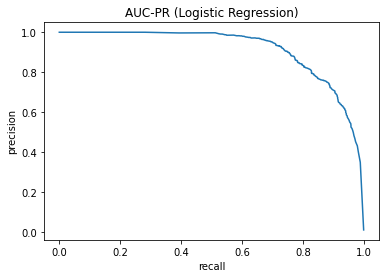

Area Under PR curve: 0.91504


In [152]:
model = RandomForestClassifier(criterion='entropy', max_features='auto', n_estimators=300)

pipe_dif = Pipeline([
        ('categ_enc_', WOEEncoder(cols=categorical_features)),
        ('scaler_', StandardScaler()),
        ('selector', RFE(model, n_features_to_select=k_best, step=30)),
        ('model_', model)                
])

pipe_dif.fit(X_train, y_train)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_pred = pipe_dif.predict_proba(X_test)
precision, recall, thershold = precision_recall_curve(y_test, y_pred[:, 1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('AUC-PR (Logistic Regression)')
plt.show()

print('Area Under PR curve:', round(auc(recall, precision), 5))

In [153]:
# Area Under PR curve: 0.91367

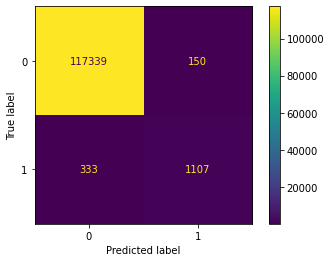

In [154]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_rf = pipe_dif.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_dif.classes_)
disp.plot();